### Segmenting_and_Clustering_Neighborhoods_in_Toronto  
#### import all necessary libraries

In [148]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import folium
from IPython.display import Image
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
%matplotlib notebook

#### scrap the webpage and get all elements for processing

In [2]:
def get_strings(soup,text):
    import re
    for tag in soup.find_all(text):
        yield(tag.string)

In [3]:
# Get and parse the html file 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_doc = requests.get(url)
soup = BeautifulSoup(html_doc.text,'lxml')
colnames = [i.split('\n')[0] for i in get_strings(soup.tbody,'th')]
colvalues = [i.split('\n')[0] if bool(i) else 'Not assigned' for i in get_strings(soup.tbody,'td') ]

In [4]:
# Move elements to their coresponding columns
code = [colvalues[count*3] for count in range(0,int(len(colvalues)/3))]
city = [colvalues[count*3+1] for count in range(0,int(len(colvalues)/3))]
neighbor = [colvalues[count*3+2] for count in range(0,int(len(colvalues)/3))]

#### Table operation to yield the final result

In [5]:
df_post = pd.DataFrame({'a':code,'b':city,'c':neighbor})
df_post.columns = colnames
df_post = df_post.replace('Not assigned',np.nan)
df_post['Neighbourhood'].fillna(df_post['Borough'],inplace = True)
df_post.dropna(axis = 0,inplace = True)

In [6]:
df_post_final = pd.DataFrame(df_post.groupby(['Postcode','Borough'])['Neighbourhood'].agg('unique')).reset_index()
df_post_final['Neighbourhood'] = df_post_final['Neighbourhood'].apply(lambda x: ','.join(x))

In [28]:
df_post_final.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,Scarborough
1,M1C,Scarborough,Scarborough
2,M1E,Scarborough,"Guildwood,Scarborough"
3,M1G,Scarborough,Scarborough
4,M1H,Scarborough,Scarborough


In [10]:
df_post_final.shape

(103, 3)

#### Merge postcode data with geo locaiton data

In [25]:
df_post_final_cor = df_post_final.merge(pd.read_csv('Geospatial_Coordinates.csv'),left_on= 'Postcode',right_on = 'Postal Code')
df_post_final_cor = df_post_final_cor[['Postcode','Borough','Neighbourhood','Latitude','Longitude']]

In [108]:
df_post_final_cor.shape

(103, 5)

In [145]:
# create map of Toronto using latitude and longitude values
map_newyork = folium.Map(location=[df_post_final_cor.Latitude.mean(), df_post_final_cor.Longitude.mean()], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_post_final_cor['Latitude'], df_post_final_cor['Longitude'], df_post_final_cor['Borough'], df_post_final_cor['Postcode']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

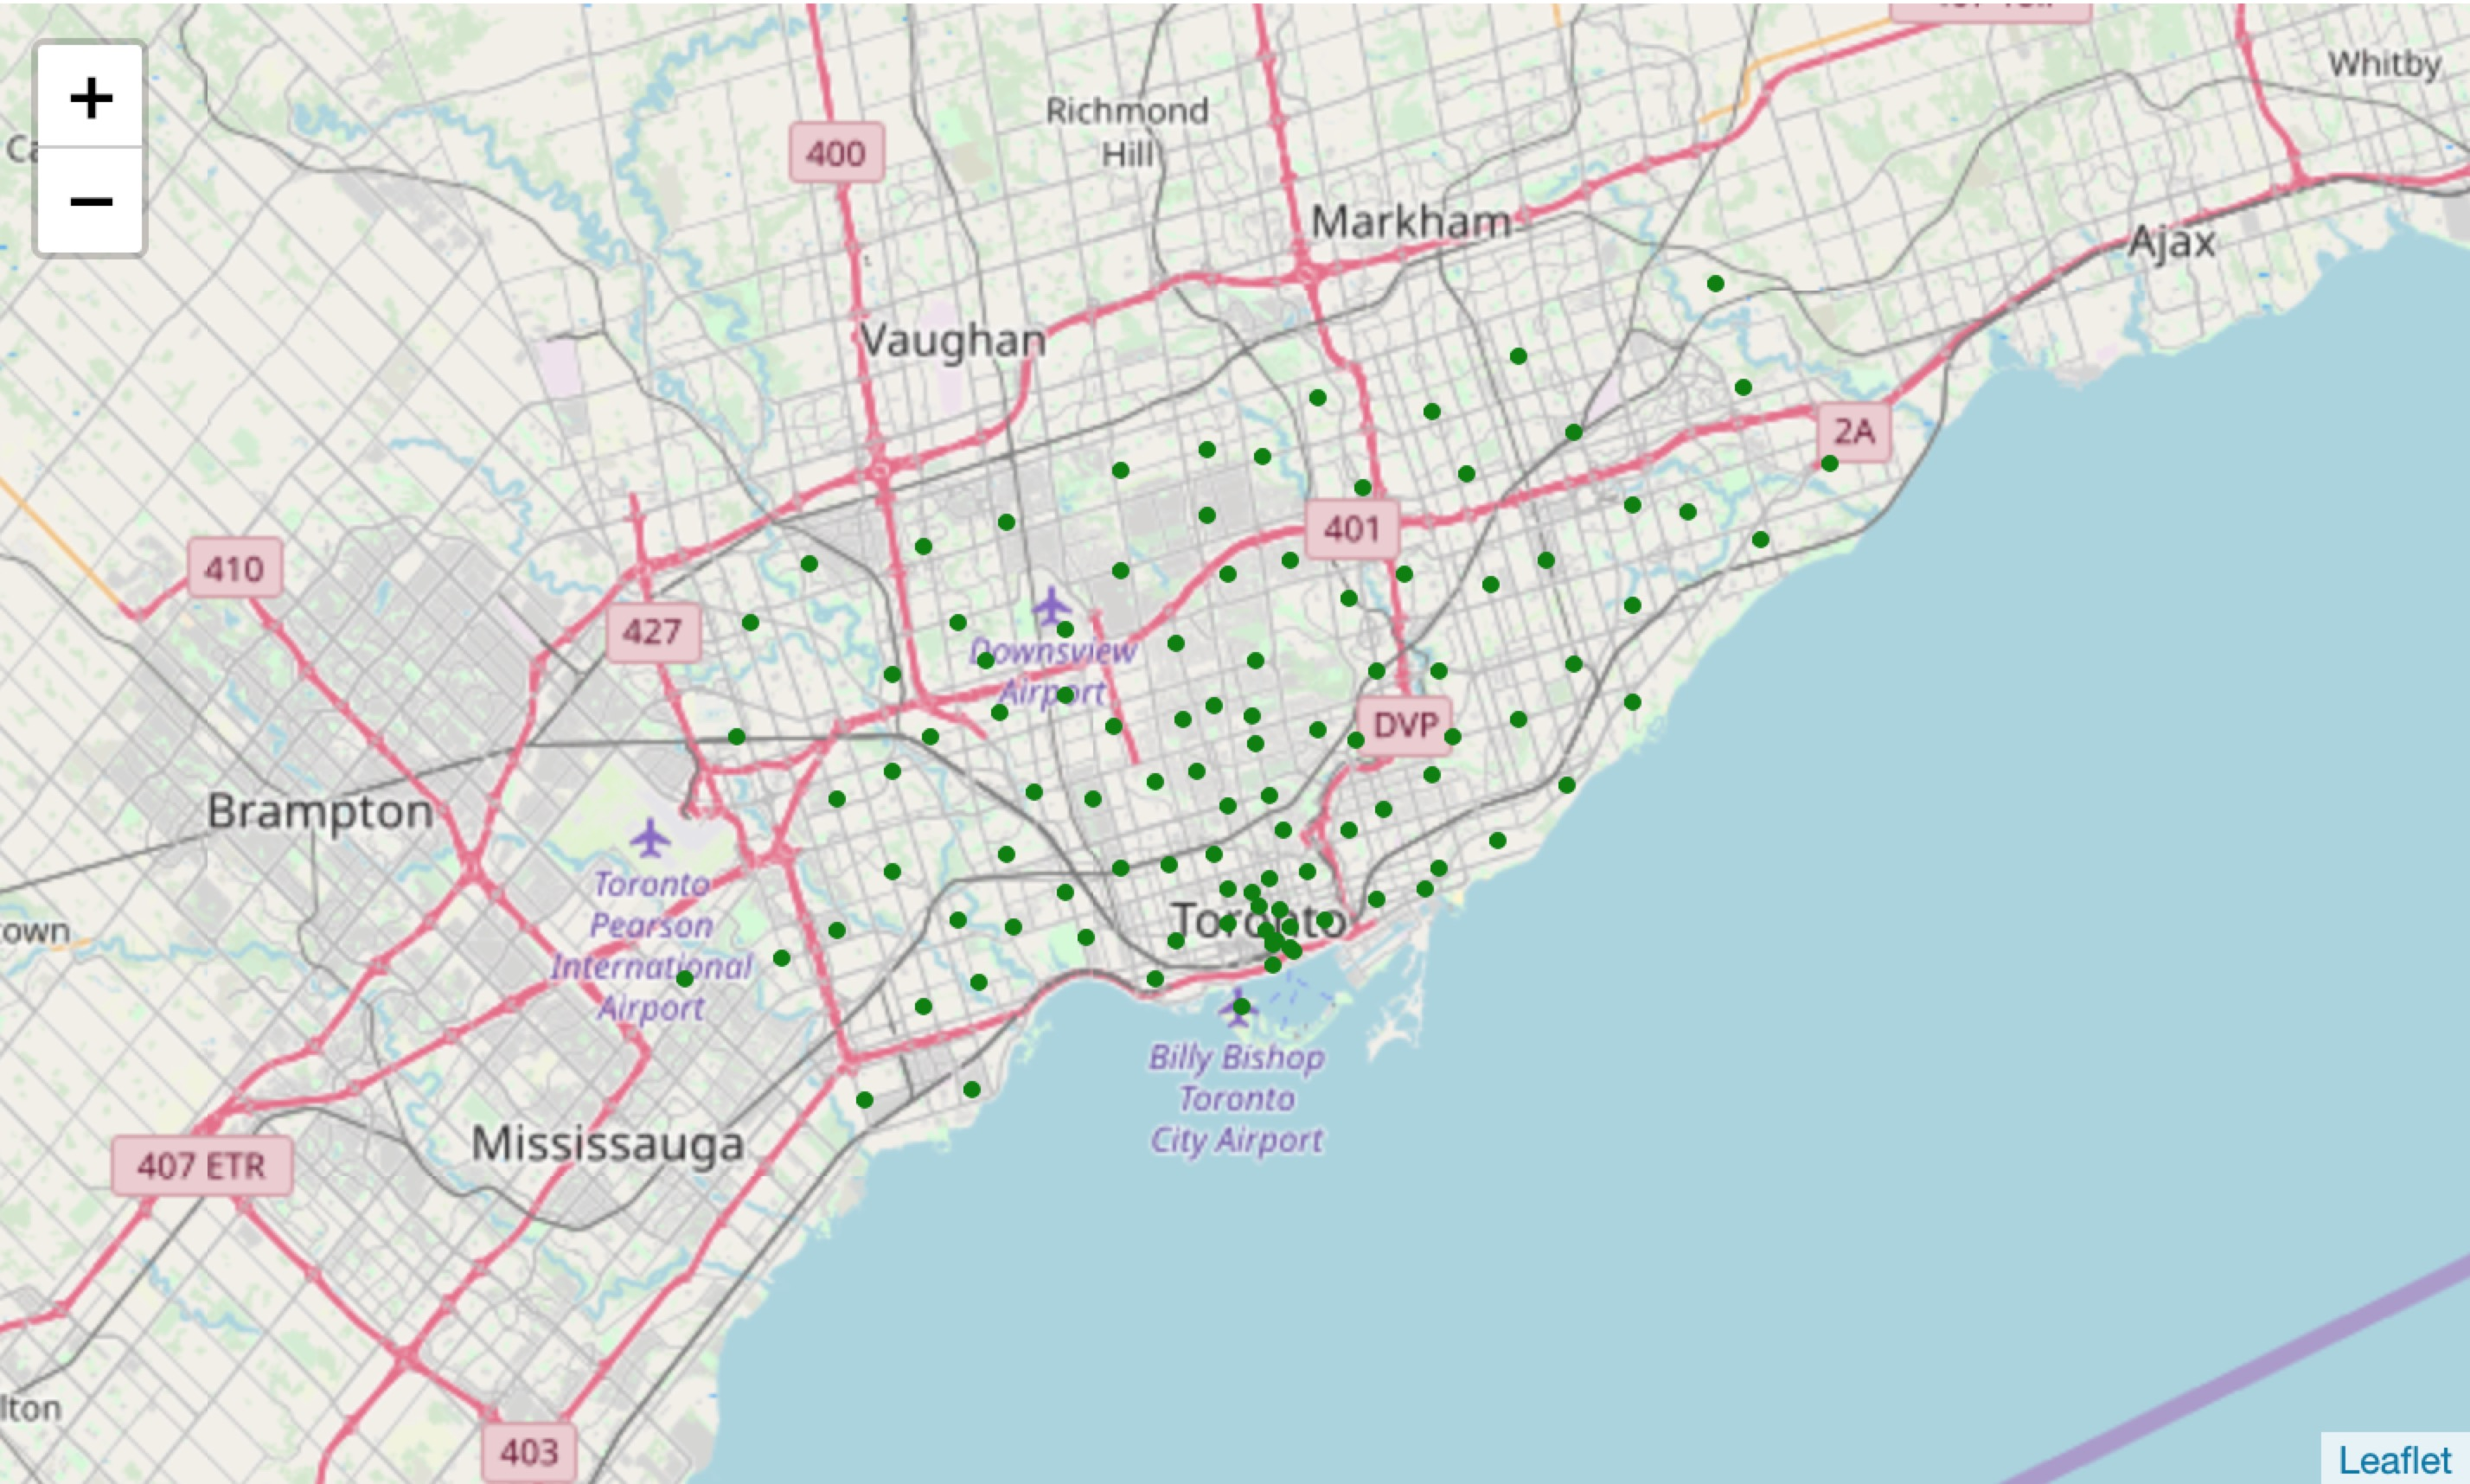

In [151]:
Image('fig1.jpg')

In [86]:
# Use the function from week3 to get nearby venues for each Postcode
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

In [88]:
Toronto_venues = getNearbyVenues(df_post_final_cor.Postcode, df_post_final_cor.Latitude, df_post_final_cor.Longitude, radius=500)

In [90]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


In [102]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Postcode'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# Getting the percentage of venues is each postcode region 
Toronto_grouped = Toronto_onehot.groupby('Postcode').mean().apply(lambda x:x*100).reset_index()


In [123]:
#### use kmean to cluster the postcode regions 

In [127]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Postcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [131]:
Toronto_grouped.columns

Index(['Postcode', 'Accessories Store', 'Adult Boutique', 'Afghan Restaurant',
       'Airport', 'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal',
       ...
       'Vegetarian / Vegan Restaurant', 'Video Game Store', 'Video Store',
       'Vietnamese Restaurant', 'Warehouse Store', 'Wine Bar', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Cluster'],
      dtype='object', length=277)

In [132]:
df_Toronto_cluster = df_post_final_cor.merge(Toronto_grouped[['Postcode','Cluster']],on = 'Postcode')

In [143]:
df_Toronto_cluster.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster
0,M1B,Scarborough,Scarborough,43.806686,-79.194353,0
1,M1C,Scarborough,Scarborough,43.784535,-79.160497,0
2,M1E,Scarborough,"Guildwood,Scarborough",43.763573,-79.188711,0
3,M1G,Scarborough,Scarborough,43.770992,-79.216917,0
4,M1H,Scarborough,Scarborough,43.773136,-79.239476,0


In [142]:
# create map
map_clusters = folium.Map(location=[df_post_final_cor.Latitude.mean(), df_post_final_cor.Longitude.mean()], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_Toronto_cluster['Latitude'], df_Toronto_cluster['Longitude'], df_Toronto_cluster['Postcode'], df_Toronto_cluster['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

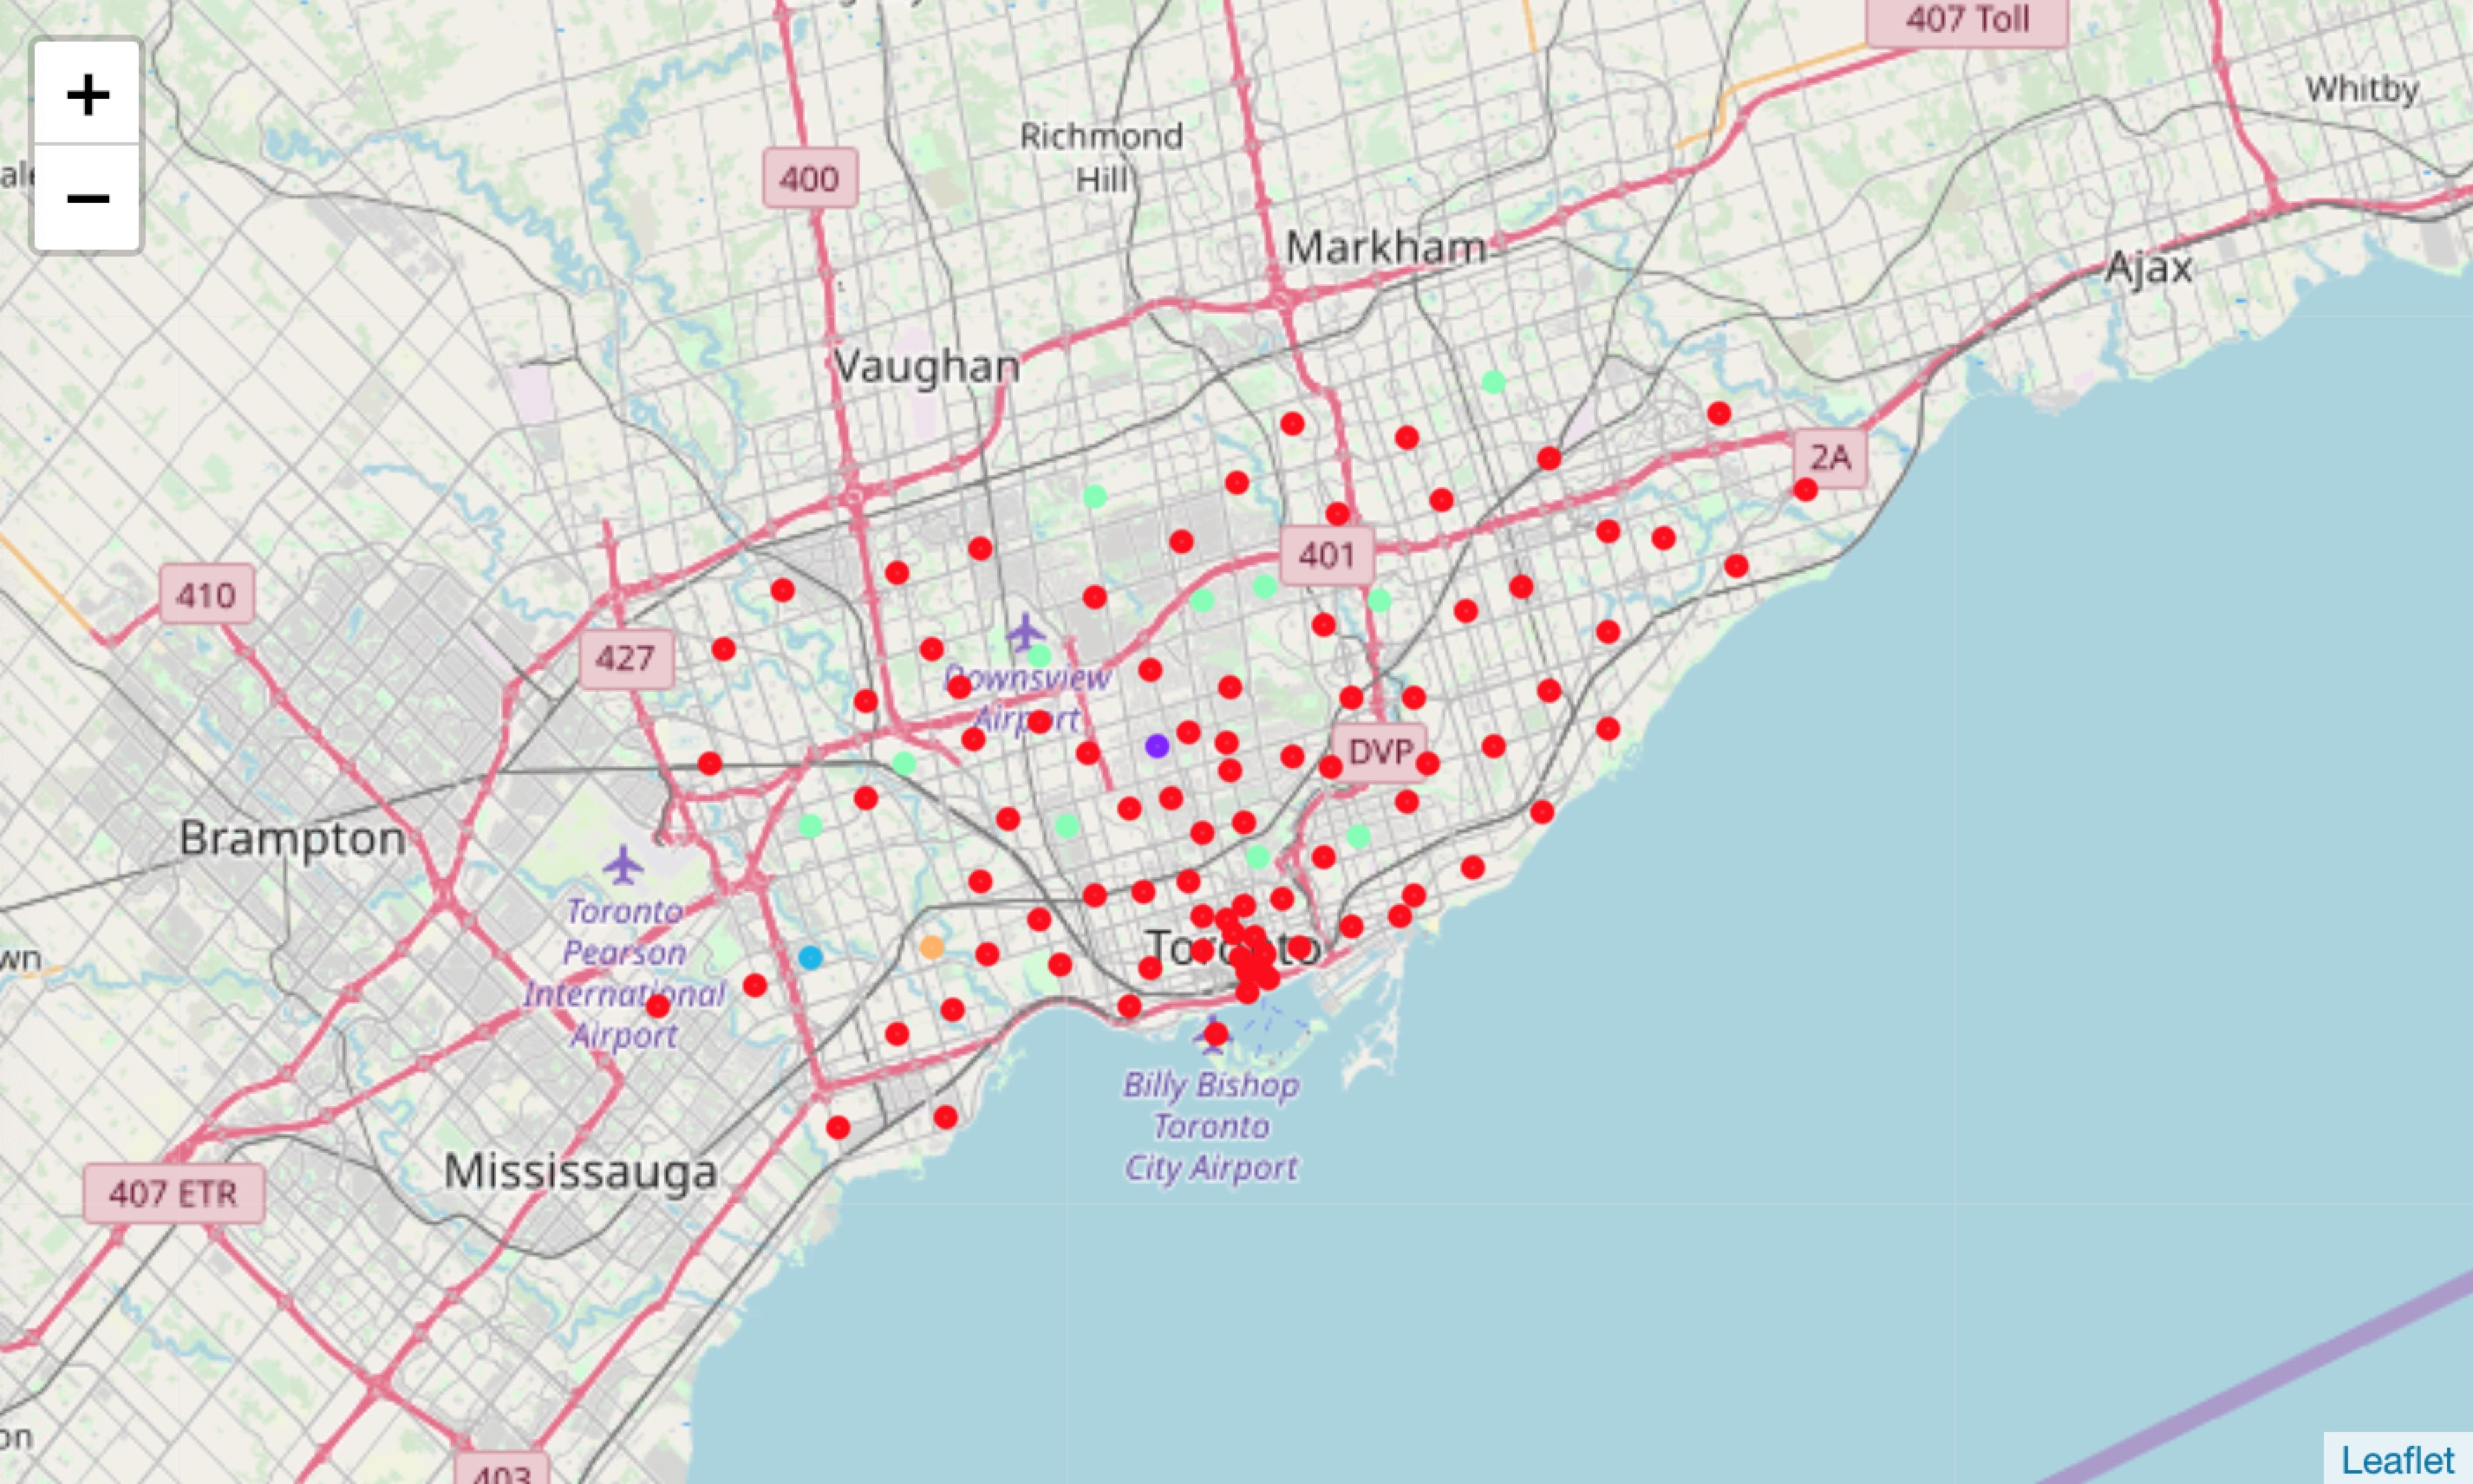

In [150]:
Image('fig2.jpg')

In [160]:
import pandas as pd
import numpy as np
import requests

from bs4 import BeautifulSoup


source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'html5lib')

postal_codes_dict = {} # initialize an empty dictionary to save the data in
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
                print(neighborhoods)
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
                print(neighborhoods_clean)
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_data = pd.DataFrame(columns=columns)
toronto_data

# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    toronto_data = toronto_data.append({"PostalCode": postal_code, 
                                        "Borough": borough, 
                                        "Neighborhood": neighborhood},
                                        ignore_index=True)

# print number of rows of dataframe
toronto_data.shape[0]

0

In [156]:
neighborhoods_clean

NameError: name 'neighborhoods_clean' is not defined

In [158]:
postal_code

'M9W'

In [161]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)[0]


In [162]:
df

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned
